## Linearität

Das folgende Beispiel benutzt Daten über das Bruttoinlandsprodukt pro Kopf (`gdppc`) und die Staatsausgaben als Prozent vom BIP (`spending`) für 142 Länder. Die Daten sind in der Datei `gdppc.csv` gespeichert. Wir möchten die Beziehung zwischen den beiden Variablen untersuchen und starten mit einem einfachen linearen Modell:

$$
\text{gdppc}_i = \beta_0 + \beta_1 \text{spending}_i + e_i, \quad e_i \sim N(0, \sigma^2)
$$


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from patsy import dmatrices

gdpsp = pd.read_csv("https://raw.githubusercontent.com/febse/data/main/econ/gdpgov2019.csv").dropna()
gdpsp.head()

,country,year,gdppc,spending
1,Albania,2019,5345.058,29.153132
2,Algeria,2019,3953.402,41.784138
4,Angola,2019,2612.246,20.402984
5,Antigua and Barbuda,2019,17495.760,22.618979
6,Argentina,2019,10054.023,37.702665


/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



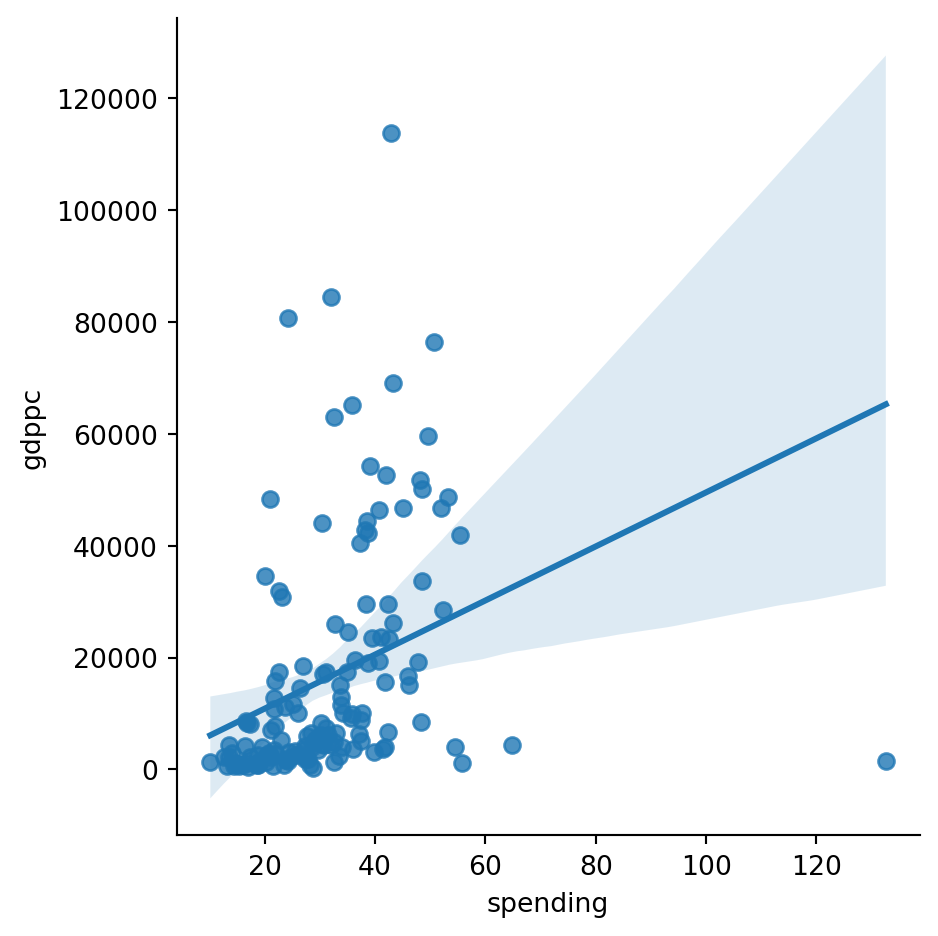

In [2]:
sns.lmplot(x="spending", y="gdppc", data=gdpsp)

In [3]:
gdpsp.sort_values(by="spending").tail(10)

,country,year,gdppc,spending
46,Denmark,2019,59678.596,49.667778
128,Norway,2019,76518.169,50.674256
17,Belgium,2019,46780.073,51.888048
91,Kuwait,2019,28513.431,52.340009
58,Finland,2019,48667.723,53.281525
112,"Micronesia, Fed. States of",2019,3979.627,54.456060
59,France,2019,41924.837,55.351806
96,Lesotho,2019,1159.368,55.809805
108,Marshall Islands,2019,4302.655,64.756959
88,Kiribati,2019,1492.126,132.572621


In [4]:
mod1 = ols("gdppc ~ spending", data=gdpsp).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gdppc   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     16.55
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           7.86e-05
Time:                        15:25:13   Log-Likelihood:                -1605.1
No. Observations:                 142   AIC:                             3214.
Df Residuals:                     140   BIC:                             3220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1219.7136   4105.423      0.297      0.767   -6896.928    9336.355
spending     483.2885    118.781      4.069      0.000     248.452     718.125
==============================================================================
Omnibus:                       60.957   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.037
Skew:                           1.643   Prob(JB):                     9.93e-44
Kurtosis:                       7.762   Cond. No.                         85.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Als Nächstes möchten wir untersuchen, ob diese Beziehung auch in verschiedenen Gruppen von Ländern gilt. Wir definieren die Gruppen anhand des Bruttoinlandsprodukts pro Kopf und speichern die Gruppenzugehörigkeit in der Variable `gdppc_group`:

-   Low: if $\text{gdppc} \leq 1025$
-   Medium-low: if $1025 < \text{gdppc} \leq 3995$
-   Medium-high: if $3995 < \text{gdppc} \leq 12375$
-   High: if $12375 < \text{gdppc} \leq 30000$
-   Very high: if $\text{gdppc} > 30000$

Count the number of countries in each category

In [5]:
gdpsp["gdppc_gr"] = pd.cut(
    gdpsp["gdppc"], 
    bins=[0, 1025, 3995, 12375, 30000, np.inf], 
    labels=["Low", "Medium-low", "Medium-high", "High", "Very high"]
)

gdpsp.head()

,country,year,gdppc,spending,gdppc_gr
1,Albania,2019,5345.058,29.153132,Medium-high
2,Algeria,2019,3953.402,41.784138,Medium-low
4,Angola,2019,2612.246,20.402984,Medium-low
5,Antigua and Barbuda,2019,17495.760,22.618979,High
6,Argentina,2019,10054.023,37.702665,Medium-high


In [6]:
gdpsp["gdppc_gr"].value_counts()

gdppc_gr
Medium-high    40
Medium-low     36
Very high      27
High           26
Low            13
Name: count, dtype: int64

Nun möchten wir die kategoriale Variable `gdppc_group` in unser Modell aufnehmen. Wir könnten dies tun, indem wir die Gruppen in separate Variablen umwandeln und sie als separate Prädiktoren in unser Modell aufnehmen. Das Modell würde dann folgendermaßen aussehen: 

$$
\text{gdppc}_i = \beta_0 + \beta_{\text{gdppc\_gr}_i} + e_i, e_i \sim N(0, \sigma^2)
$$

oder equivalent:

$$
\begin{align*}
\text{gdppc}_i & = \beta_0 + \\
& \beta_{\text{Med Low}} x_{\text{gdppc\_gr=Med Low}} + \\
& \beta_{\text{Med High}} x_{\text{gdppc\_gr=Med High}} + \\
& \beta_{\text{High}} x_{\text{gdppc\_gr=High}} + \\
& \beta_{\text{Very High}} x_{\text{gdppc\_gr=Very High}} + \\
& e_i\\
& e_i \sim N(0, \sigma^2)
\end{align*}
$$


In [7]:
mod2 = ols("gdppc ~ gdppc_gr", data=gdpsp).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gdppc   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     177.0
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           4.38e-53
Time:                        15:25:13   Log-Likelihood:                -1483.9
No. Observations:                 142   AIC:                             2978.
Df Residuals:                     137   BIC:                             2992.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 712.2514   2359.420      0.302      0.763   -3953.340    5377.843
gdppc_gr[T.Medium-low]   1754.0958   2752.657      0.637      0.525   -3689.094    7197.286
gdppc_gr[T.Medium-high]  6315.7737   2715.897      2.325      0.022     945.275    1.17e+04
gdppc_gr[T.High]         1.924e+04   2889.688      6.657      0.000    1.35e+04     2.5e+04
gdppc_gr[T.Very high]    5.281e+04   2871.795     18.390      0.000    4.71e+04    5.85e+04
==============================================================================
Omnibus:                      126.634   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2560.171
Skew:                           2.935   Prob(JB):                         0.00
Kurtosis:                      22.956   Cond. No.                         8.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Um die geschätzten Koeffizienten zu verstehen, ist ein Vergleich mit den Gruppenmittelwerten hilfreich.

In [8]:
mod2.params

Intercept                    712.251385
gdppc_gr[T.Medium-low]      1754.095838
gdppc_gr[T.Medium-high]     6315.773740
gdppc_gr[T.High]           19236.702769
gdppc_gr[T.Very high]      52811.176245
dtype: float64

In [9]:
gdpsp.groupby("gdppc_gr")["gdppc"].mean()

/tmp/ipykernel_135483/1539639733.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



gdppc_gr
Low              712.251385
Medium-low      2466.347222
Medium-high     7028.025125
High           19948.954154
Very high      53523.427630
Name: gdppc, dtype: float64

Wir sehen, dass im Modell eine der Dummy-Variablen weggelassen wurde. Dies ist notwendig, um die Identifizierbarkeit des Modells zu gewährleisten. Die weggelassene Gruppe wird als Referenzgruppe bezeichnet.

In [10]:
y, X = dmatrices('gdppc ~ gdppc_gr', data=gdpsp, return_type='dataframe')
X

,Intercept,gdppc_gr[T.Medium-low],gdppc_gr[T.Medium-high],gdppc_gr[T.High],gdppc_gr[T.Very high]
1,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0
6,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
184,1.0,0.0,0.0,1.0,0.0
185,1.0,1.0,0.0,0.0,0.0
186,1.0,1.0,0.0,0.0,0.0
187,1.0,1.0,0.0,0.0,0.0


Bisher haben wir t-Tests verwendet, um Hypothesen über einzelne Koeffizienten im Regressionsmodell zu testen. In diesem Beispiel möchten wir jedoch eine Hypothese über mehrere Koeffizienten gleichzeitig testen.

$$
F = \frac{(RSS_{\text{restricted}} - RSS_{\text{unrestricted}}) / (p_{\text{restricted}} - p_{\text{unrestricted}})}{RSS_{\text{unrestricted}} / (n - p_{\text{unrestricted}})}
$$

wobei $RSS$ der Residual Sum of Squares ist, $p$ die Anzahl der Koeffizienten im Modell und $n$ die Anzahl der Beobachtungen.

In [11]:
# ANOVA
# The zero model is the model with no predictors, i.e. the mean of the dependent variable

mod0 = ols("gdppc ~ 1", data=gdpsp).fit()

anova_lm(mod0, mod1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,141.0,6.115267e+10,0.0,NaN,NaN,NaN
1,140.0,5.468617e+10,1.0,6.466503e+09,16.554652,0.000079


Nachdem wir wissen, wie wir die Gruppenzugehörigkeit in unser Modell aufnehmen können, werden wir das erste Modell erweitern.

$$
\text{gdppc}_i = \beta_0 + \beta_{\text{gdppc\_gr}[i]} + \beta_1 \text{spending}_i + e_i, e_i \sim N(0, \sigma^2)
$$

oder equivalent:

$$
\begin{align*}
\text{gdppc}_i & = \beta_0 + \\
& \beta_{\text{Med Low}} x_{\text{gdppc\_gr=Med Low}} + \\
& \beta_{\text{Med High}} x_{\text{gdppc\_gr=Med High}} + \\
& \beta_{\text{High}} x_{\text{gdppc\_gr=High}} + \\
& \beta_{\text{Very High}} x_{\text{gdppc\_gr=Very High}} \\
& \beta_1 \text{spending}_i + \\
& e_i, \\
& e_i \sim N(0, \sigma^2)
\end{align*}
$$

In [12]:
m3 = ols("gdppc ~ spending + gdppc_gr", data=gdpsp).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gdppc   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     141.4
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           4.52e-52
Time:                        15:25:13   Log-Likelihood:                -1483.5
No. Observations:                 142   AIC:                             2979.
Df Residuals:                     136   BIC:                             2997.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -144.3893   2593.150     -0.056      0.956   -5272.501    4983.722
gdppc_gr[T.Medium-low]   1308.3199   2811.846      0.465      0.642   -4252.277    6868.917
gdppc_gr[T.Medium-high]  5835.9387   2784.606      2.096      0.038     329.211    1.13e+04
gdppc_gr[T.High]         1.846e+04   3051.440      6.050      0.000    1.24e+04    2.45e+04
gdppc_gr[T.Very high]    5.192e+04   3082.839     16.842      0.000    4.58e+04     5.8e+04
spending                   44.7960     55.906      0.801      0.424     -65.762     155.354
==============================================================================
Omnibus:                      127.601   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2565.305
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      22.955   Cond. No.                         269.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
m3p = m3.get_prediction().summary_frame()
m3p = pd.concat([gdpsp, m3p], axis=1)

m3p.head()


,country,year,gdppc,spending,gdppc_gr,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
1,Albania,2019,5345.058,29.153132,Medium-high,6997.492936,1347.376100,4332.974809,9662.011062,-10057.090016,24052.075887
2,Algeria,2019,3953.402,41.784138,Medium-low,3035.692668,1587.579202,-103.841692,6175.227027,-14099.528918,20170.914253
4,Angola,2019,2612.246,20.402984,Medium-low,2077.902578,1500.179842,-888.794234,5044.599391,-15026.495475,19182.300632
5,Antigua and Barbuda,2019,17495.760,22.618979,High,19329.058404,1840.989666,15688.389450,22969.727358,2094.975509,36563.141299
6,Argentina,2019,10054.023,37.702665,Medium-high,7380.477774,1416.846215,4578.578273,10182.377275,-9696.108056,24457.063604


/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='spending', ylabel='gdppc'>

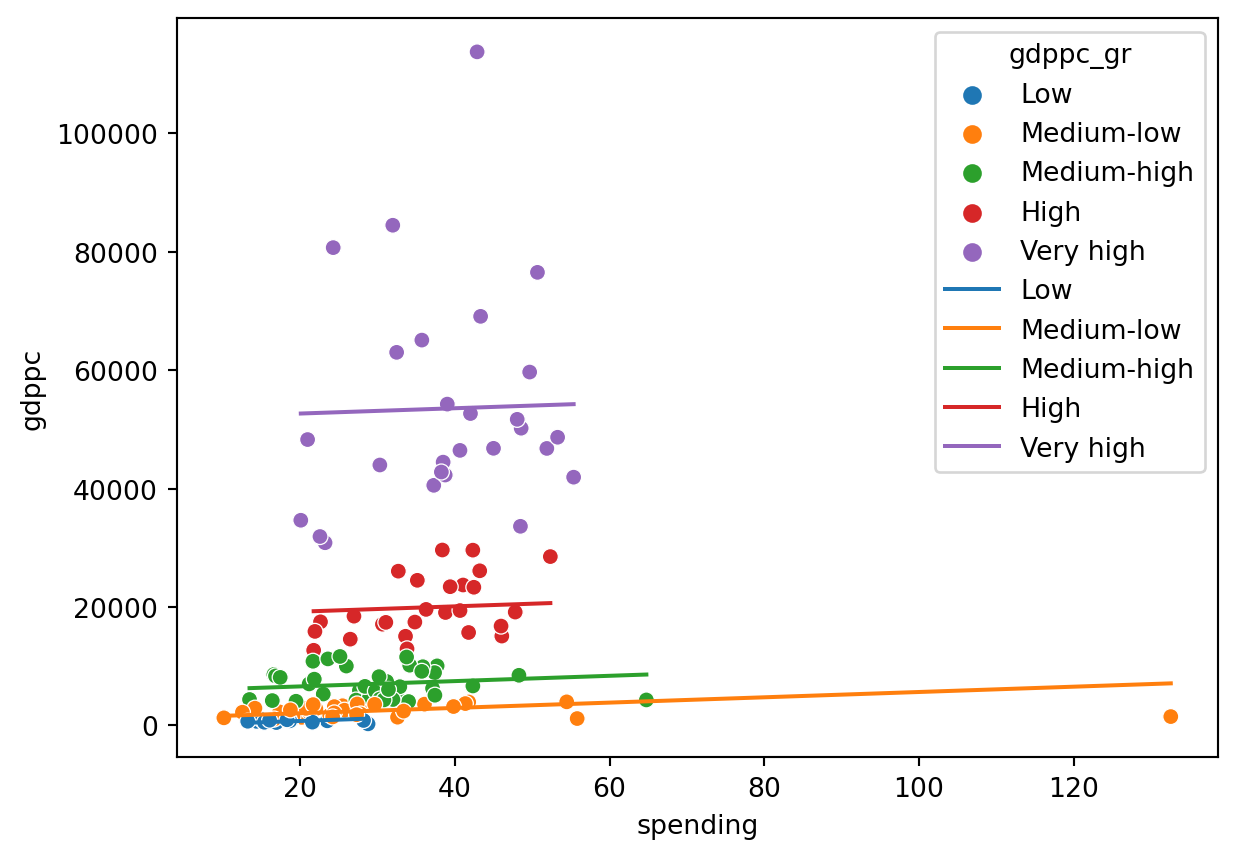

In [14]:
sns.scatterplot(x="spending", y="gdppc", hue="gdppc_gr", data=m3p)
sns.lineplot(x="spending", y="mean", data=m3p, hue="gdppc_gr")


## Polynomiale Regression


/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



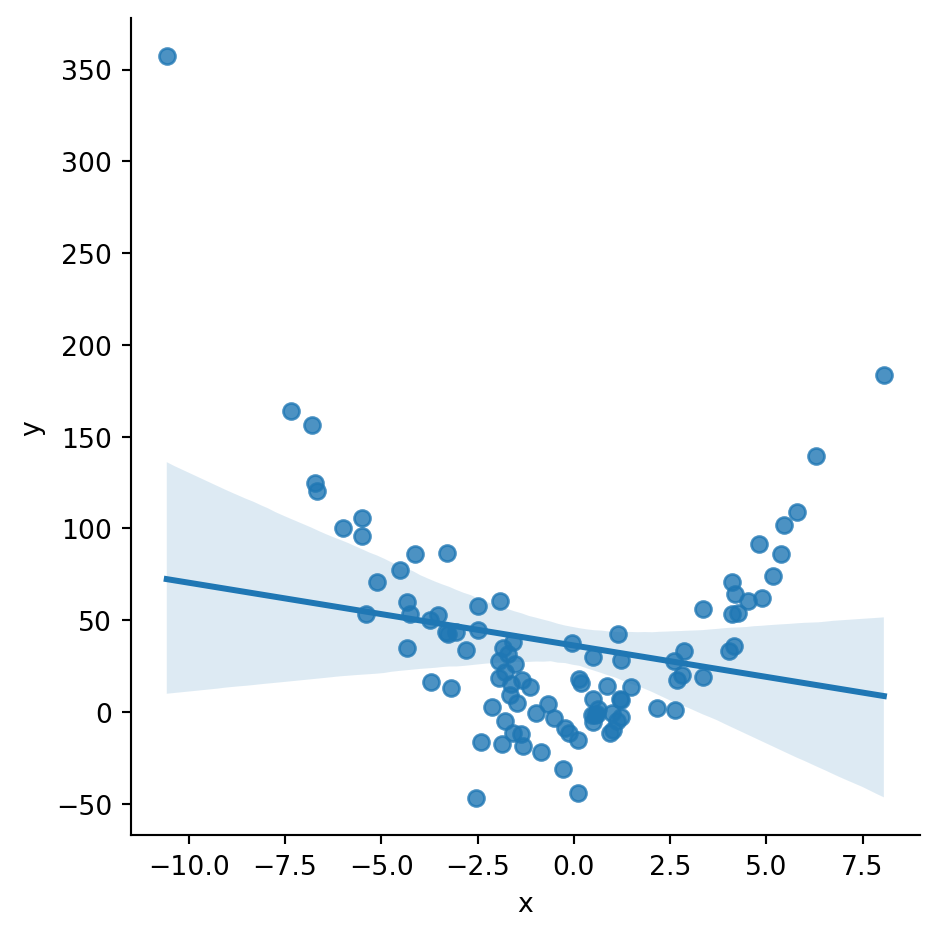

In [15]:
# Simulation

x = np.random.normal(size=100, scale=4)
y = 2 + 3*x**2 + np.random.normal(size=100, scale=20)

dt = pd.DataFrame({"x": x, "y": y})

sns.lmplot(data=dt, x="x", y="y")

/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



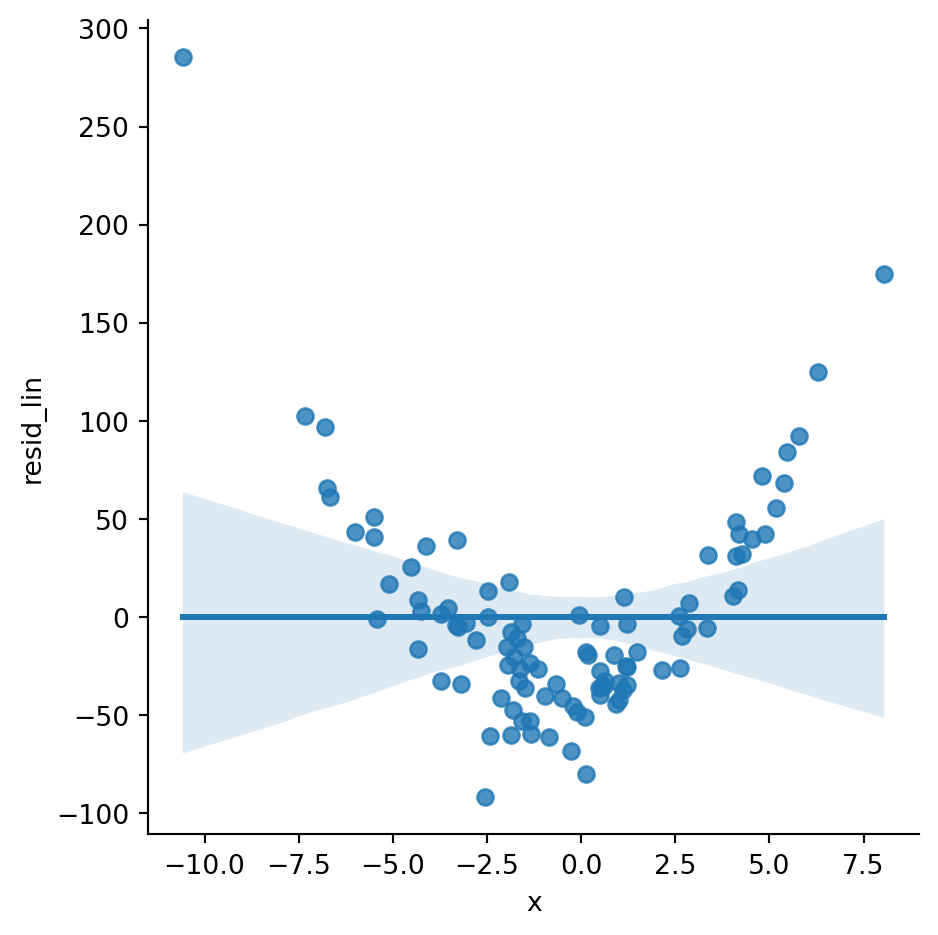

In [16]:
mod_lin = ols("y ~ x", data=dt).fit()

dt["resid_lin"] = mod_lin.resid

sns.lmplot(data=dt, x="x", y="resid_lin")

In [17]:
mq = ols("y ~ x + I(x**2)", data=dt).fit()

pred_mq = mq.get_prediction(dt).summary_frame()

dt_with_pred = pd.concat([dt, pred_mq], axis=1)
dt_with_pred.head()

,x,y,resid_lin,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-1.699230,31.473769,-10.600745,10.113841,2.460628,5.230175,14.997506,-29.612003,49.839684
1,4.109158,53.528268,31.318558,52.293592,3.523648,45.300126,59.287058,12.253599,92.333585
2,-1.795723,-4.971789,-47.376310,11.153567,2.462889,6.265414,16.041720,-28.572829,50.879963
3,-5.502399,105.887058,50.805630,94.154692,3.846410,86.520633,101.788751,53.997858,134.311526
4,-3.532173,52.960684,4.617468,39.586348,2.680464,34.266369,44.906327,-0.195490,79.368186


/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/amarov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



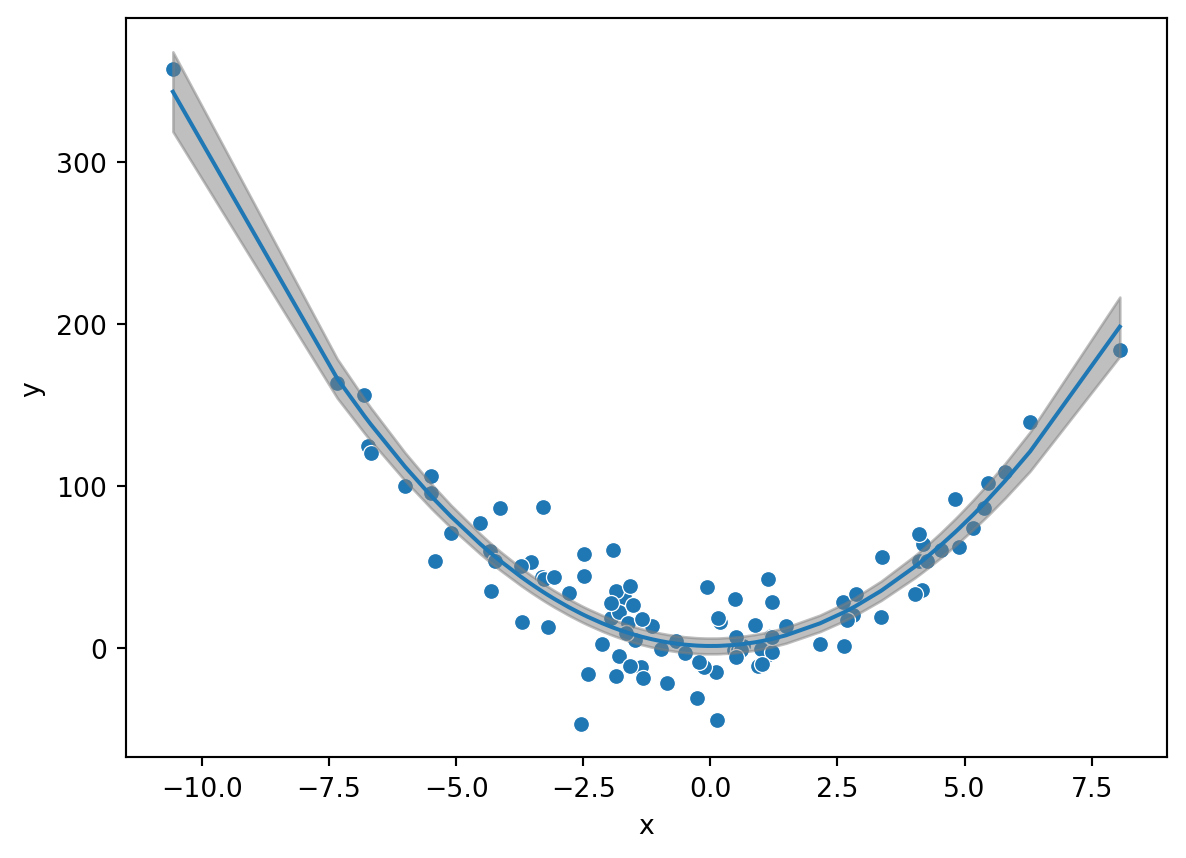

In [18]:
ax = sns.scatterplot(x="x", y="y", data=dt_with_pred)
sns.lineplot(x="x", y="mean", data=dt_with_pred, ax=ax)

dt_sorted = dt_with_pred.sort_values(by="x")

ax.fill_between(dt_sorted["x"], dt_sorted["mean_ci_lower"], dt_sorted["mean_ci_upper"], color="gray", alpha=0.5)